<a href="https://www.kaggle.com/code/parsahriri/gans-for-image-augmentation?scriptVersionId=190998917" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Advanced data augmentation for image - part 1
* reference:  https://github.com/rossettisimone/AUGMENTATION_GAN
* dose it improve your model? pleas let us know in the comment 
* Are you intrested in knowing more?? https://www.nature.com/articles/s41598-019-52737-x
* please check the discussion page for more information
* Would you like to see more ? pleas like the page 

*** why fake data is not so good? it is trained on a very small dataset for sake of GPU! go bigger ***

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import datetime
import os
import os.path
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
from torch.utils.data import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import clear_output
from tqdm import tqdm

In [2]:

%cd /kaggle/input/isic-2024-challenge/train-image/image

/kaggle/input/isic-2024-challenge/train-image/image


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
# Number of training epochs
num_epochs = 200
LOAD_MODEL = True

#PATH='/AUGMENTATION_GAN/gan_models/epoch_200/p_virus_200_2020-08-22_15:49:13.dat' #P_vir_200_opt
#PATH='/AUGMENTATION_GAN/gan_models/epoch_200/p_bacteria_200_2020-08-22_16:21:47.dat' #P_bac_200_opt
#PATH='/AUGMENTATION_GAN/gan_models/epoch_200/normal_200_2020-08-22_16:38:52.dat' #Normal_200_opt
#PATH='/AUGMENTATION_GAN/gan_models/epoch_200/covid_200_2020-08-22_16:58:21.dat' #Covid_200_opt

TRAIN_ALL = False
#All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Learning rate for optimizers
lr = 0.002
lr_d = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Beta2 hyperparam for Adam optimizers
beta2 = 0.999

real_label = 1.
fake_label = 0.
# Input to generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device) #batch of 64
# Define Loss function
criterion = nn.BCELoss()

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
# class Generator(nn.Module):

#     def __init__(self):
#         super(Generator, self).__init__()
#         self._model = nn.Sequential(
#             # input is Z, going into a convolution
#             #i/p,o/p,kernel size,stride,padding
#             nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 16),
#             nn.ReLU(True),
#             # state size. (ngf*16) x 4 x 4
#             nn.ConvTranspose2d( ngf * 16, ngf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True),
#             # state size. (ngf*8) x 8 x 8
#             nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 16 x 16
#             nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 32 x 32
#             nn.ConvTranspose2d( ngf*2, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. (nc) x 64 x 64
#         )

#     def forward(self, input):
#         return self._model(input)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [6]:
# class Discriminator(nn.Module):

#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self._model = nn.Sequential(
#             # input is (nc) x 64 x 64
#             nn.Conv2d(nc, ndf * 2, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 32 x 32
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 16 x 16
#             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*8) x 8 x 8
#             nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 16),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*16) x 4 x 4
#             nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         return self._model(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.5),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.5),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.Dropout(p=0.25),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [7]:
def plot(name, train_epoch, values, path, save):
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure()
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('epoch: %s -> %s: %s' % (train_epoch, name, values[-1]))
    fig = plt.ylabel(name)
    fig = plt.xlabel('train_set')
    fig = plt.plot(values)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
    if save:
        now = datetime.datetime.now()
        get_fig.savefig('%s/%s_%.3f_%d_%s.png' %
                        (path, name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H:%M:%S")))

In [8]:
import os
def save_model(generator, discriminator, gen_optimizer, dis_optimizer, metrics, num_epochs):
    now = datetime.datetime.now()
    g_losses = metrics['train.G_losses'][-1]
    d_losses = metrics['train.D_losses'][-1]
    name = "%+.3f_%+.3f_%d_%s.dat" % (g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S"))
    fname = os.path.join('.', '/kaggle/working/augGAN/model', name)
    states = {
            'state_dict_generator': generator.state_dict(),
            'state_dict_discriminator': discriminator.state_dict(),
            'gen_optimizer': gen_optimizer.state_dict(),
            'dis_optimizer': dis_optimizer.state_dict(),
            'metrics': metrics,
            'train_epoch': num_epochs,
            'date': now.strftime("%Y-%m-%d_%H:%M:%S"),
    }
    torch.save(states, fname)
    path='/kaggle/working/augGAN/plots/train_%+.3f_%+.3f_%s'% (g_losses, d_losses, now.strftime("%Y-%m-%d_%H:%M:%S"))
    try:
        os.makedirs(path, exist_ok=True)
    except Exception as error:
        print(error)
    try:
        os.mkdir(os.path.join('.', path))
    except Exception as error:
        print(error)

    plot('G_losses', num_epochs, metrics['train.G_losses'], path, True)
    plot('D_losses', num_epochs, metrics['train.D_losses'], path, True)
    plot('D_x', num_epochs, metrics['train.D_x'], path, True)
    plot('D_G_z1', num_epochs, metrics['train.D_G_z1'], path, True)
    plot('D_G_z2', num_epochs, metrics['train.D_G_z2'], path, True)

In [9]:
img_list = []
G_losses = []
D_losses = []

def train_gan(generator, discriminator, gen_optimizer, dis_optimizer, train_loader, num_epochs, metrics):
        iters = 0
        print("GAN training started :D...")

        for epoch in range(num_epochs):
            print("Epoch %d" %(epoch+1))
            # For each batch in the dataloader
            for i, data in enumerate(tqdm(train_loader, 0)):
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ## Train with all-real batch
                discriminator.zero_grad()
                # Format batch
                b_real = data[0].to(device)
                b_size = b_real.size(0)
                label = torch.full((b_size,), real_label, device=device)
                # Forward pass real batch through D
                output = discriminator(b_real).view(-1)
                # Calculate loss on all-real batch
                errD_real = criterion(output, label)
                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()
                metrics['train.D_x'].append(D_x)

                ## Train with all-fake batch
                # Generate batch of latent vectors
                noise = torch.randn(b_size, nz, 1, 1, device=device)
                # Generate fake image batch with G
                fake = generator(noise)
                label.fill_(fake_label)
                # Classify all fake batch with D
                output = discriminator(fake.detach()).view(-1)
                # Calculate D's loss on the all-fake batch
                errD_fake = criterion(output, label)
                # Calculate the gradients for this batch
                errD_fake.backward()
                D_G_z1 = output.mean().item()
                metrics['train.D_G_z1'].append(D_G_z1)
                # Add the gradients from the all-real and all-fake batches
                errD = errD_real + errD_fake
                # Update D
                dis_optimizer.step()
                # if i>0:
                #     if errD.item()>G_losses[i-1]:
                #         dis_optimizer.step()
                # else:
                #     dis_optimizer.step()

                # (2) Update G network: maximize log(D(G(z)))
                generator.zero_grad()
                label.fill_(real_label)  # fake labels are real for generator cost
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = discriminator(fake).view(-1)
                # Calculate G's loss based on this output
                errG = criterion(output, label)
                # Calculate gradients for G
                errG.backward()
                D_G_z2 = output.mean().item()
                metrics['train.D_G_z2'].append(D_G_z2)
                # Update G
                gen_optimizer.step()

                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())
                metrics['train.G_losses'].append(errG.item())
                metrics['train.D_losses'].append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
                    with torch.no_grad():
                        fake = generator(fixed_noise).detach().cpu()
                    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters += 1
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader),
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        save_model(generator, discriminator, gen_optimizer, dis_optimizer, metrics, num_epochs)

In [10]:
def get_indices(dataset, class_name, indices):
    j = 0
    for i in range(len(dataset.targets)):
        if dataset.targets[i] == class_name:
            indices.append(i)
            j += 1
    print("Total Samples of class", class_name,"found are",j)
    return indices

In [11]:
def test1(generator, discriminator, num_epochs, metrics):
    print('Testing Block.........')
    now = datetime.datetime.now()
    g_losses = metrics['train.G_losses'][-1]
    d_losses = metrics['train.D_losses'][-1]
    path='/kaggle/working/augGAN/output_images'
    try:
      os.mkdir(os.path.join('.', path))
    except Exception as error:
      print(error)

    test_img_list = []
    test_noise = torch.randn(batch_size, nz, 1, 1, device=device)
    test_fake = generator(test_noise).detach().cpu()
    test_img_list.append(vutils.make_grid(test_fake, padding=2, normalize=True))
    fig = plt.figure(figsize=(15,15))
    fig = plt.axis("off")
    fig = plt.title("Fake Images")
    fig = plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))
    get_fig = plt.gcf()
    fig = plt.show()
    get_fig.savefig('%s/image_%.3f_%.3f_%d_%s.png' %
                    (path, g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S")))

In [12]:
def test2(generator, discriminator, num_epochs, metrics, loader):
    print('Testing Block.........')
    now = datetime.datetime.now()
    g_losses = metrics['train.G_losses'][-1]
    d_losses = metrics['train.D_losses'][-1]
    path='/kaggle/working/augGAN/output_images'
    try:
      os.mkdir(os.path.join('.', path))
    except Exception as error:
      print(error)

    real_batch = next(iter(loader))
    
    test_img_list = []
    test_noise = torch.randn(batch_size, nz, 1, 1, device=device)
    test_fake = generator(test_noise).detach().cpu()
    test_img_list.append(vutils.make_grid(test_fake, padding=2, normalize=True))

    fig = plt.figure(figsize=(15,15))
    ax1 = plt.subplot(1,2,1)
    ax1 = plt.axis("off")
    ax1 = plt.title("Real Images")

    ax2 = plt.subplot(1,2,2)
    ax2 = plt.axis("off")
    ax2 = plt.title("Fake Images")
    ax2 = plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))
    #ax2 = plt.show()
    fig.savefig('%s/image_%.3f_%.3f_%d_%s.png' %
                    (path, g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S")))

In [13]:

def test_fake(generator, discriminator, metrics, n_images, folname):
    now = datetime.datetime.now()
    g_losses = metrics['train.G_losses'][-1]
    d_losses = metrics['train.D_losses'][-1]
    #path='augGAN/output_images/%+.3f_%+.3f_%d_%s'% (g_losses, d_losses, n_images, now.strftime("%Y-%m-%d_%H:%M:%S"))
    path='main_folder/'+str(n_images)+'/'+folname
    try:
      os.mkdir(os.path.join('.', path))
    except Exception as error:
      print(error)

    im_batch_size = 50
    #n_images=100
    for i_batch in range(0, n_images, im_batch_size):
        gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
        gen_images = generator(gen_z)
        dis_result = discriminator(gen_images).view(-1)
        images = gen_images.to("cpu").clone().detach()
        images = images.numpy().transpose(0, 2, 3, 1)
        for i_image in range(gen_images.size(0)):
            save_image(gen_images[i_image, :, :, :], os.path.join(path, 
                        f'image_{i_batch+i_image:04d}.png'), normalize= True)

    print('Testing Block.........')
    print('Discriminator_mean: ', dis_result.mean().item())
    #import shutil
    #shutil.make_archive('images', 'zip', './augGAN/output_images')

In [14]:
from torch.utils.data import Dataset
from PIL import Image
import os
from torch.utils.data import DataLoader, Dataset, Subset


class CustomImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, 0  # Return 0 as a dummy label if you don't have labels
data_dir = '/kaggle/input/isic-2024-challenge/train-image/image'

mu = (0.5,0.5,0.5)
sigma = (0.5,0.5,0.5)
transform = transforms.Compose([#transforms.RandomHorizontalFlip(),
                                    transforms.Resize((64,64)),
                                    #transforms.Scale(imageSize),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mu, sigma)])
# Use the custom dataset


trainset = CustomImageDataset(data_dir, transform=transform)

subset_size = 100    #of samples in the subset
subset_indices = random.sample(range(len(trainset)), subset_size)
subset_dataset = Subset(trainset, subset_indices)

trainset = subset_dataset

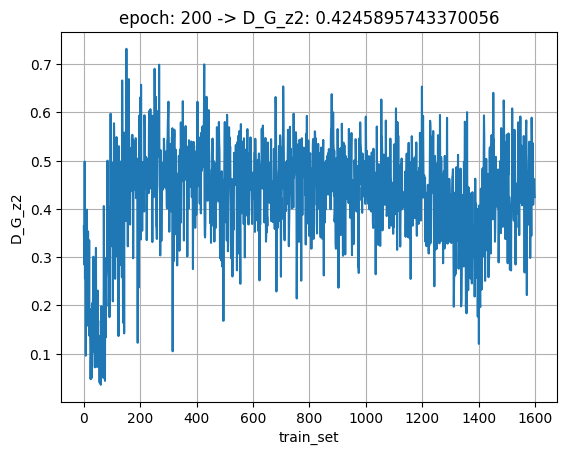

Testing Block.........
Testing Block.........
[Errno 17] File exists: '/kaggle/working/augGAN/output_images'


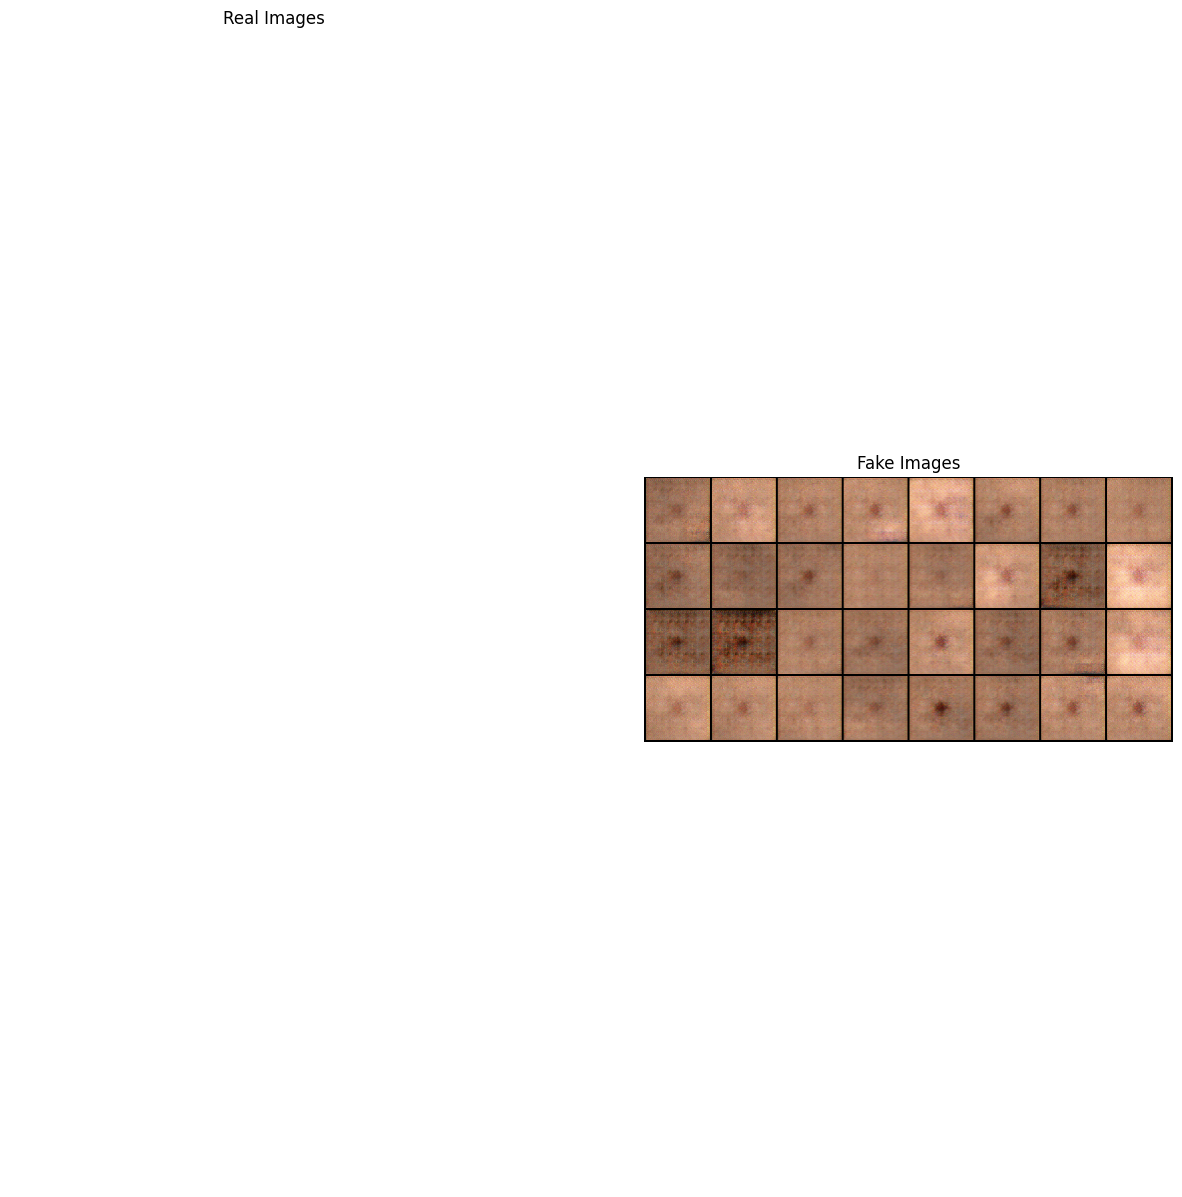

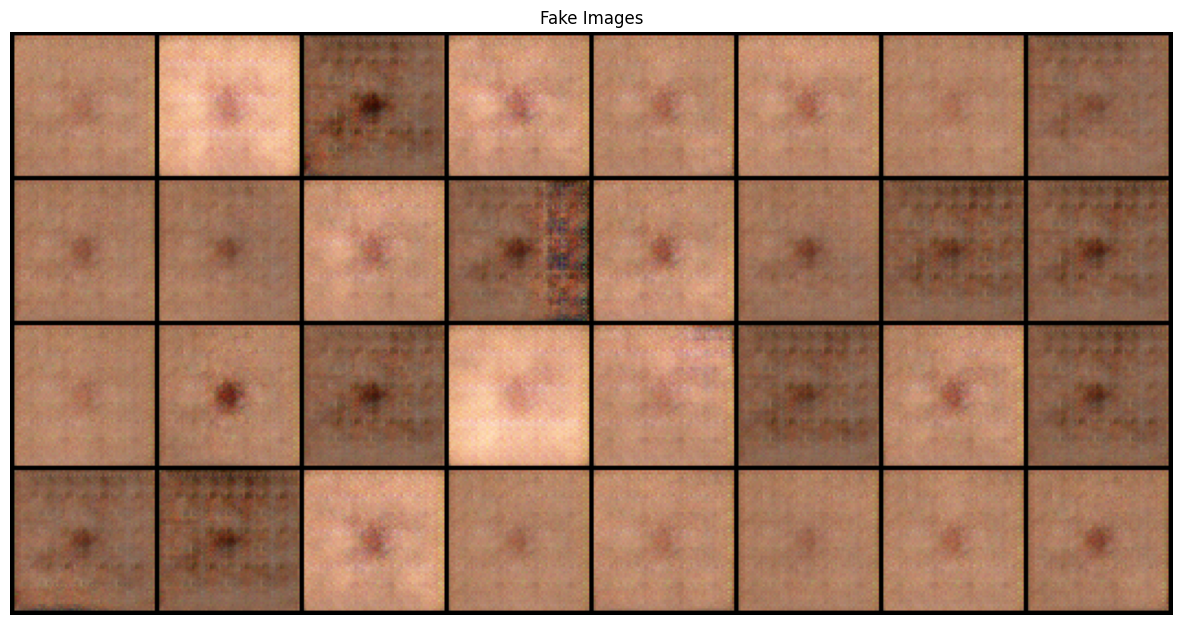

In [15]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)
gen_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
dis_optimizer = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, beta2))


METRIC_FIELDS = [
    'train.D_x',
    'train.D_G_z1',
    'train.D_G_z2',
    'train.G_losses',
    'train.D_losses',
]
metrics = {field: list() for field in METRIC_FIELDS}


TRAIN_ALL = False

if TRAIN_ALL:
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                  shuffle=True)
    train_gan(generator, discriminator, gen_optimizer, dis_optimizer, train_loader,
              num_epochs, metrics)
    test2(generator, discriminator, num_epochs, metrics, train_loader)
else:
    # idx = []
    # idx = get_indices(train_set, 4, idx) #second argument is 0 for covid; 1 for normal; 2 for pneumonia_bacteria; 3 for pneumonia_virus for x-ray dataset
 
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                  shuffle=True)
    mask =[x[1]==0 for x in train_loader.dataset] #here is 0 for covid; 1 for normal; 2 for pneumonia_bacteria; 3 for pneumonia_virus for x-ray dataset
    idx= np.arange(len(train_loader.dataset))[mask]

    print("Total samples now are ",len(idx))
    selected_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                      sampler = SubsetRandomSampler(idx))
    try:
        train_gan(generator, discriminator, gen_optimizer, dis_optimizer, selected_loader,num_epochs, metrics)
    except:
        model_dir = '/kaggle/working/augGAN'
        os.makedirs(model_dir, exist_ok=True)
        model_dir = '/kaggle/working/augGAN/model'
        os.makedirs(model_dir, exist_ok=True)
        train_gan(generator, discriminator, gen_optimizer, dis_optimizer, selected_loader,num_epochs, metrics)
    test2(generator, discriminator, num_epochs, metrics, selected_loader)
    test1(generator, discriminator, num_epochs, metrics)

In [16]:
#Testing cell....to visualize 
test_batch = 1 #No of images to be genertaed in stack 
test_fake_id = 1 #To generate fake images or just view real images
LOAD_ID = 0 #Class of images in case test_fake_id is 0
generator = Generator().to(device)
discriminator = Discriminator().to(device)

if test_fake_id:
  #check for fake image
  test_img_list = []
  test_noise = torch.randn(test_batch, nz, 1, 1, device=device)
  test_img = generator(test_noise)#.detach().cpu()

else:
  #check for real image
  idx = []
  #train_set = datasets.ImageFolder("main_folder/100/", transform=transform)
  idx = get_indices(train_set, LOAD_ID, idx) 
  test_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch,
                                                sampler = SubsetRandomSampler(idx))
  data = next(iter(test_loader))
  test_noise, test_class_lable = data
  test_img.data.resize_(test_noise.size()).copy_(test_noise)
  #print(data[0].size())
  print('class label for real', test_class_lable)

s_output = discriminator(test_img.detach().to(device))
print('Discriminator s o/p', s_output)



Discriminator s o/p tensor([[[[0.3481]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [17]:
!pip install torchsummary

In [18]:
from torchsummary import summary

summary(generator, (100, 1, 1))
summary(discriminator, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [19]:
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [20]:
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.25, inplace=False)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14